In [1]:
#@title Установка пакетов и проверка GPU
!pip -q install -U kaggle umap-learn pydot graphviz

import os, sys, json, pathlib, itertools, math, random, shutil, time
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)

import tensorflow as tf
from tensorflow import keras
print("TensorFlow:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))

TensorFlow: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
#@title Загрузка kaggle.json и скачивание датасета (нажмите «Выбрать файлы»)
from google.colab import files
uploaded = files.upload()  # ожидается файл 'kaggle.json'

assert 'kaggle.json' in uploaded, "Загрузите именно kaggle.json"

os.makedirs("/root/.kaggle", exist_ok=True)
with open("/root/.kaggle/kaggle.json", "wb") as f:
    f.write(uploaded['kaggle.json'])
os.chmod("/root/.kaggle/kaggle.json", 0o600)

DATA_ROOT = Path("/content/data/car parts")
DATA_ROOT.mkdir(parents=True, exist_ok=True)

# Скачивание и распаковка
!kaggle datasets download -d gpiosenka/car-parts-40-classes -p /content/data -q
!unzip -qo /content/data/car-parts-40-classes.zip -d /content/data

# Проверка структуры
for cand in ["train","valid","validation","val","test"]:
    p = DATA_ROOT/cand
    print(cand, "→", p.exists(), p)

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/gpiosenka/car-parts-40-classes
License(s): apache-2.0
train → True /content/data/car parts/train
valid → True /content/data/car parts/valid
validation → False /content/data/car parts/validation
val → False /content/data/car parts/val
test → True /content/data/car parts/test


Found 6917 files belonging to 40 classes.
Found 200 files belonging to 40 classes.
Found 200 files belonging to 40 classes.
Классов: 40
Пример имён классов: ['AIR COMPRESSOR', 'ALTERNATOR', 'BATTERY', 'BRAKE CALIPER', 'BRAKE PAD', 'BRAKE ROTOR', 'CAMSHAFT', 'CARBERATOR', 'COIL SPRING', 'CRANKSHAFT']


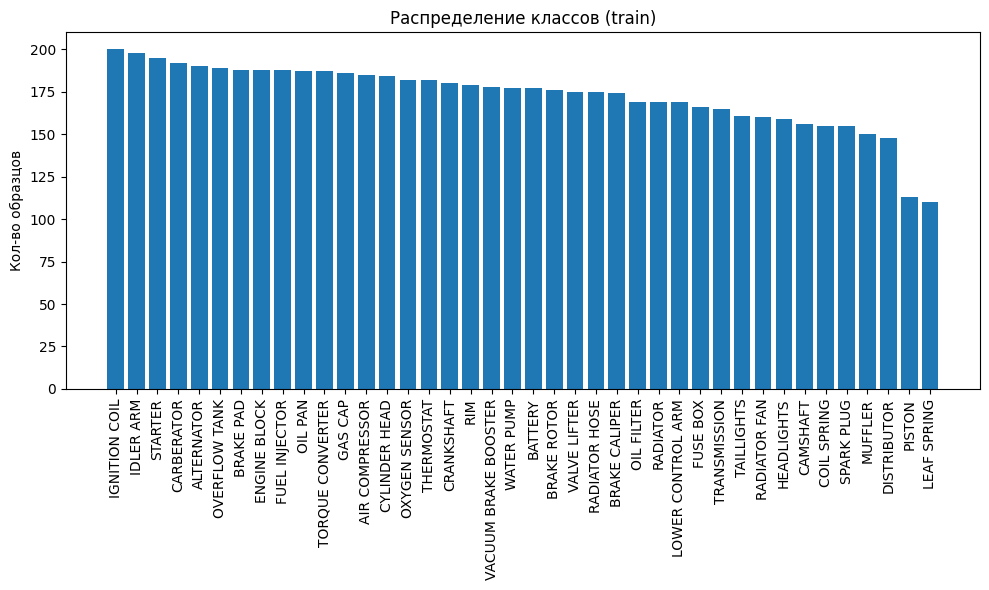

In [5]:
#@title Загрузка датасетов (train/val/test), карта классов, баланс
from typing import Tuple, List

AUTOTUNE = tf.data.AUTOTUNE

def _find_first(root: Path, names: List[str]):
    for n in names:
        p = root / n
        if p.exists() and p.is_dir():
            return p
    return None

IMG_SIZE = 300  #@param {type:"slider", min:224, max:384, step:8}
BATCH_SIZE = 32 #@param {type:"slider", min:16, max:64, step:8}
SEED = 1337     # фиксируем для воспроизводимости

def make_datasets(root_dir: Path, img_size=IMG_SIZE, batch_size=BATCH_SIZE, seed=SEED):
    train_dir = _find_first(root_dir, ["train","Train","training"])
    val_dir   = _find_first(root_dir, ["valid","validation","val","Valid","Validation"])
    test_dir  = _find_first(root_dir, ["test","Test","testing"])

    assert train_dir is not None and val_dir is not None, "Не найдены train/valid каталоги"

    def ds_from(d, shuffle):
        return tf.keras.utils.image_dataset_from_directory(
            d, labels="inferred", label_mode="int",
            image_size=(img_size, img_size), batch_size=batch_size,
            shuffle=shuffle, seed=seed
        )

    ds_train = ds_from(train_dir, True)
    ds_val   = ds_from(val_dir, False)
    ds_test  = ds_from(test_dir, False) if test_dir else None

    class_names = ds_train.class_names
    num_classes = len(class_names)

    # Препроцессинг и аугментации
    norm = keras.Sequential([keras.layers.Rescaling(1/255)])
    aug  = keras.Sequential([
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.15),
        keras.layers.RandomZoom(0.15),
        keras.layers.RandomContrast(0.15),
    ])

    def prep_train(x,y): return aug(norm(x)), y
    def prep_eval(x,y):  return norm(x), y

    ds_train = ds_train.map(prep_train, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    ds_val   = ds_val.map(prep_eval, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    if ds_test is not None:
        ds_test = ds_test.map(prep_eval, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

    return ds_train, ds_val, ds_test, class_names, num_classes

ds_train, ds_val, ds_test, class_names, NUM_CLASSES = make_datasets(DATA_ROOT)
print("Классов:", NUM_CLASSES)
print("Пример имен классов:", class_names[:10])

# Подсчет распределения классов в train для визуализации и class_weights
counts = np.zeros((NUM_CLASSES,), dtype=np.int64)
for _, y in ds_train.unbatch().take(100000):  # безопасная выборка
    counts[int(y.numpy())] += 1

def plot_class_distribution(counts, class_names, title="Распределение классов (train)"):
    idx = np.argsort(-counts)
    plt.figure(figsize=(10,6))
    plt.bar(np.arange(len(idx)), counts[idx])
    plt.xticks(np.arange(len(idx)), [class_names[i] for i in idx], rotation=90)
    plt.ylabel("Кол-во образцов")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_class_distribution(counts, class_names)

Found 6917 files belonging to 40 classes.


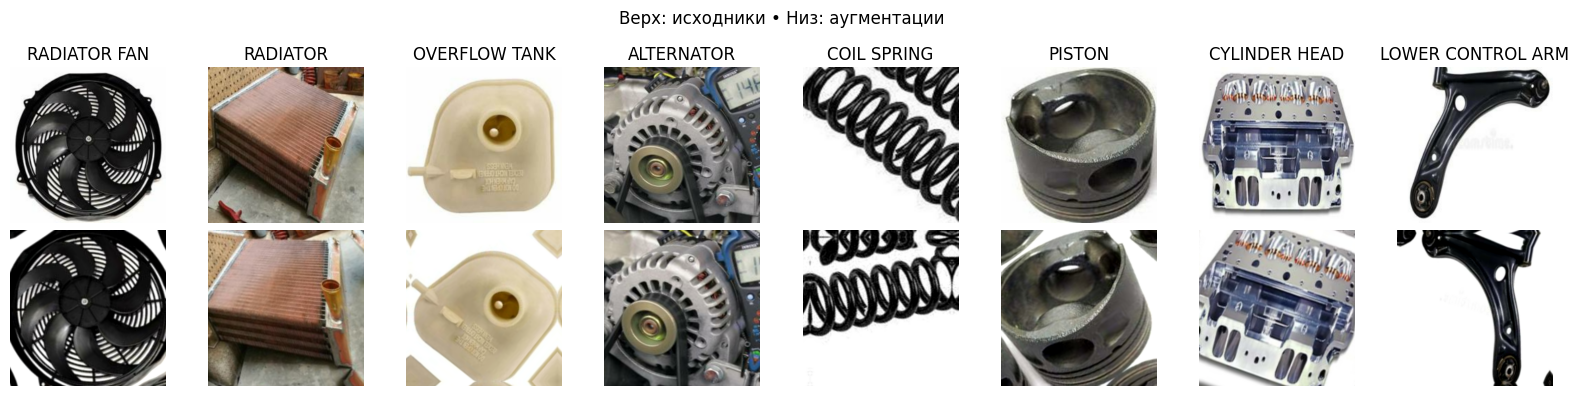

In [6]:
#@title Превью: исходники и аугментации
import matplotlib.pyplot as plt

# Берем небольшой батч из исходного датасета без препроцессинга для превью
raw_ds = tf.keras.utils.image_dataset_from_directory(
    _find_first(DATA_ROOT, ["train","Train","training"]),
    labels="inferred", label_mode="int", image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=8, shuffle=True, seed=SEED
)

aug = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.15),
    keras.layers.RandomZoom(0.15),
    keras.layers.RandomContrast(0.15),
])

x_batch, y_batch = next(iter(raw_ds))
fig, axes = plt.subplots(2, 8, figsize=(16,4))
for i in range(8):
    axes[0, i].imshow(tf.cast(x_batch[i], tf.uint8).numpy())
    axes[0, i].axis("off")
    axes[0, i].set_title(class_names[y_batch[i]])
    axes[1, i].imshow(tf.clip_by_value(aug(tf.cast(x_batch[i:i+1], tf.float32))/255.0,0,1)[0])
    axes[1, i].axis("off")
plt.suptitle("Верх: исходники • Низ: аугментации")
plt.tight_layout()
plt.show()

In [18]:
#@title ProxyAPI-классификатор вместо локальных моделей (установка SDK + клиент)
!pip -q install -U openai

import os, io, json, time, base64, hashlib, logging, itertools
from pathlib import Path
from typing import List, Dict, Tuple, Any, Optional
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from openai import OpenAI

# Ключ и base_url: берем из окружения или дефолт как в вашем примере
PROXY_API_KEY = os.getenv("OPENAI_API_KEY", "sk-gpTBIn8Bs3JNpcZcsorUMegcZVKEVQy0")
PROXY_BASE_URL = os.getenv("OPENAI_BASE_URL", "https://api.proxyapi.ru/openai/v1")
PROXY_MODEL = "gpt-4o-mini"  # можно сменить на gpt-4o / gpt-4o-mini-compact

OUT_DIR = Path("/content/outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)
CACHE_PATH = OUT_DIR / "proxy_cache.jsonl"  # кэш предсказаний (по md5 изображения + списку классов)

def build_client() -> OpenAI:
    return OpenAI(api_key=PROXY_API_KEY, base_url=PROXY_BASE_URL)

def img_to_data_uri(path: Path, max_side: int = 512, quality: int = 70) -> str:
    img = Image.open(path).convert("RGB")
    w, h = img.size
    scale = min(1.0, max_side / float(max(w, h)))
    if scale < 1.0:
        img = img.resize((int(w*scale), int(h*scale)), Image.LANCZOS)
    buf = io.BytesIO()
    img.save(buf, format="JPEG", quality=quality)
    enc = base64.b64encode(buf.getvalue()).decode()
    return "data:image/jpeg;base64," + enc

def _safe_json_parse(s: str) -> Optional[dict]:
    try:
        return json.loads(s)
    except Exception:
        return None

def _extract_text(resp) -> str:
    # Унифицированный извлекатель текста из Responses API
    try:
        if hasattr(resp, "output_text") and resp.output_text:
            return resp.output_text.strip()
        if hasattr(resp, "output") and resp.output:
            parts = []
            for itm in resp.output:
                if getattr(itm, "type", None) == "message":
                    for c in getattr(itm, "content", []):
                        t = getattr(c, "text", None)
                        if t:
                            parts.append(t)
            if parts:
                return " ".join(parts).strip()
    except Exception:
        pass
    return ""

def proxy_predict_labels(
    client: OpenAI,
    image_path: Path,
    label_options: List[str],
    model: str = PROXY_MODEL,
    temperature: float = 0.0,
    max_output_tokens: int = 200,
    retries: int = 3,
) -> List[Tuple[str, float]]:
    """
    Возвращает список топ-меток [(label, score)], где score в [0..1].
    Пытаемся получить JSON-структуру; если не получилось — делаем эвристику.
    """
    uri = img_to_data_uri(image_path)
    sys_msg = (
        "Ты — CV-ассистент. По фото автомобильной запчасти верни JSON строго формата:\n"
        "{\"top\": [{\"label\": <строка из списка>, \"score\": <число 0..1>}, ...]}\n"
        "Где top содержит до 5 лучших гипотез по убыванию score. Разрешены только метки из списка вариантов."
    )
    user_msg = [
        {"type": "input_text", "text": "Варианты меток (выбери строго из них): " + ", ".join(label_options)},
        {"type": "input_image", "image_url": uri},
    ]

    for attempt in range(retries):
        try:
            resp = client.responses.create(
                model=model,
                input=[{"role": "system", "content": sys_msg},
                       {"role": "user", "content": user_msg}],
                temperature=temperature,
                max_output_tokens=max_output_tokens,
            )
            txt = _extract_text(resp)
            data = _safe_json_parse(txt)
            if data and isinstance(data.get("top", None), list):
                pairs = []
                for item in data["top"]:
                    lab = str(item.get("label", "")).strip()
                    sc  = float(item.get("score", 0.0))
                    if lab in label_options:
                        pairs.append((lab, max(0.0, min(1.0, sc))))
                if pairs:
                    return pairs[:5]
            # Фоллбэк: ищем упоминания меток в тексте, ранжируем по порядку
            found = []
            txt_low = txt.lower()
            for lab in label_options:
                if lab.lower() in txt_low:
                    found.append(lab)
            if found:
                # равные скоры у всех найденных
                return [(lab, 1.0/len(found)) for lab in found[:5]]
        except Exception as e:
            time.sleep(1.0 + attempt * 0.5)
            if attempt == retries - 1:
                logging.error(f"[ProxyAPI error] {e}")
    # если ничего не смогли достать
    return [(label_options[0], 0.0)]  # защита от пустого ответа

def _md5_for_cache(path: Path, label_options: List[str]) -> str:
    h = hashlib.md5()
    h.update(path.read_bytes())
    h.update(("||".join(label_options)).encode("utf-8"))
    return h.hexdigest()

# Примитивный кэш JSONL: строка на изображение
def cache_load() -> Dict[str, Any]:
    if not CACHE_PATH.exists():
        return {}
    cache = {}
    with open(CACHE_PATH, "r", encoding="utf-8") as f:
        for line in f:
            try:
                obj = json.loads(line)
                cache[obj["key"]] = obj
            except Exception:
                pass
    return cache

def cache_append(key: str, payload: Dict[str, Any]):
    with open(CACHE_PATH, "a", encoding="utf-8") as f:
        f.write(json.dumps({"key": key, **payload}, ensure_ascii=False) + "\n")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 956.3/956.3 kB 21.1 MB/s eta 0:00:00


In [19]:
#@title Оценка Proxy-классификатора на валидации/тесте (confusion matrix, отчеты)
from sklearn.metrics import accuracy_score, top_k_accuracy_score, f1_score, classification_report, confusion_matrix

# Используем ранее определенные утилиты _find_first, DATA_ROOT, class_names, NUM_CLASSES
VAL_DIR = _find_first(DATA_ROOT, ["valid","validation","val"])
TEST_DIR = _find_first(DATA_ROOT, ["test","Test","testing"])
assert VAL_DIR is not None, "Не найден каталог валидации"

label_options = class_names  # список меток берем из датасета
client = build_client()
cache = cache_load()

def list_images_and_labels(root_dir: Path) -> List[Tuple[Path, int]]:
    pairs = []
    for i, cls in enumerate(label_options):
        d = root_dir / cls
        if not d.exists():
            # бывают классы без сплита
            continue
        for p in sorted(d.glob("*")):
            if p.suffix.lower() in [".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"]:
                pairs.append((p, i))
    return pairs

def predict_dir(root_dir: Path, limit_per_class: Optional[int] = None) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Возвращает y_true, y_pred_top1, proba_matrix (N x C; sparse через top-5 заполняем вероятности).
    """
    pairs = list_images_and_labels(root_dir)
    # по желанию ограничим число из каждого класса (ускорение отладки)
    if limit_per_class is not None:
        grouped: Dict[int, List[Path]] = {}
        for p, y in pairs:
            grouped.setdefault(y, []).append(p)
        pairs = list(itertools.chain.from_iterable(
            [(p, y) for p in ps[:limit_per_class]] for y, ps in grouped.items()
        ))

    y_true = []
    y_pred = []
    proba = []

    for idx, (path, y) in enumerate(pairs):
        key = _md5_for_cache(path, label_options)
        if key in cache:
            top = cache[key]["top"]  # список {"label":..., "score":...}
        else:
            top_pairs = proxy_predict_labels(client, path, label_options, model=PROXY_MODEL)
            # нормализуем, чтобы суммы не превышали 1
            s = sum(max(0.0, sc) for _, sc in top_pairs) or 1.0
            top = [{"label": lab, "score": float(sc/s)} for lab, sc in top_pairs]
            cache_append(key, {"image": str(path), "top": top})

        # собираем вероятностный вектор по top-5
        prob_vec = np.zeros((len(label_options),), dtype=np.float32)
        for t in top:
            try:
                j = label_options.index(t["label"])
                prob_vec[j] = max(prob_vec[j], float(t["score"]))
            except ValueError:
                pass
        pred = int(np.argmax(prob_vec))

        y_true.append(y)
        y_pred.append(pred)
        proba.append(prob_vec)

        if (idx+1) % 20 == 0:
            print(f"[{idx+1}/{len(pairs)}] {path.name} → pred={label_options[pred]} (true={label_options[y]})")

    return np.array(y_true), np.array(y_pred), np.vstack(proba)

# ───── Запуск оценки ─────
print("Валидация через ProxyAPI…")
y_true_v, y_pred_v, proba_v = predict_dir(VAL_DIR, limit_per_class=None)  # можно поставить число для ускорения

val_acc  = accuracy_score(y_true_v, y_pred_v)
val_top5 = top_k_accuracy_score(y_true_v, proba_v, k=5, labels=list(range(len(label_options))))
val_f1   = f1_score(y_true_v, y_pred_v, average="macro")
print(f"VAL: acc={val_acc:.4f} | top5={val_top5:.4f} | F1(macro)={val_f1:.4f}")

if TEST_DIR is not None:
    print("Тест через ProxyAPI…")
    y_true_t, y_pred_t, proba_t = predict_dir(TEST_DIR, limit_per_class=None)
    test_acc  = accuracy_score(y_true_t, y_pred_t)
    test_top5 = top_k_accuracy_score(y_true_t, proba_t, k=5, labels=list(range(len(label_options))))
    test_f1   = f1_score(y_true_t, y_pred_t, average="macro")
    print(f"TEST: acc={test_acc:.4f} | top5={test_top5:.4f} | F1(macro)={test_f1:.4f}")
else:
    y_true_t = y_pred_t = proba_t = None

Валидация через ProxyAPI…
[20/200] 5.jpg → pred=BRAKE CALIPER (true=BRAKE CALIPER)
[40/200] 5.jpg → pred=CARBERATOR (true=CARBERATOR)
[60/200] 5.jpg → pred=DISTRIBUTOR (true=DISTRIBUTOR)
[80/200] 5.jpg → pred=GAS CAP (true=GAS CAP)
[100/200] 5.jpg → pred=LEAF SPRING (true=LEAF SPRING)
[120/200] 5.jpg → pred=OIL PAN (true=OIL PAN)
[140/200] 5.jpg → pred=RADIATOR (true=RADIATOR)
[160/200] 5.jpg → pred=ALTERNATOR (true=SPARK PLUG)
[180/200] 5.jpg → pred=TORQUE CONVERTER (true=TORQUE CONVERTER)
[200/200] 5.jpg → pred=ENGINE BLOCK (true=WATER PUMP)
VAL: acc=0.7500 | top5=0.9750 | F1(macro)=0.7609
Тест через ProxyAPI…
[20/200] 5.jpg → pred=BRAKE CALIPER (true=BRAKE CALIPER)
[40/200] 5.jpg → pred=CARBERATOR (true=CARBERATOR)
[60/200] 5.jpg → pred=ALTERNATOR (true=DISTRIBUTOR)
[80/200] 5.jpg → pred=GAS CAP (true=GAS CAP)
[100/200] 5.jpg → pred=LEAF SPRING (true=LEAF SPRING)
[120/200] 5.jpg → pred=OIL PAN (true=OIL PAN)
[140/200] 5.jpg → pred=RADIATOR (true=RADIATOR)
[160/200] 5.jpg → pred=SPAR


VAL classification report (усечён):

                      precision    recall  f1-score   support

      AIR COMPRESSOR       1.00      1.00      1.00         5
          ALTERNATOR       0.38      1.00      0.56         5
             BATTERY       1.00      0.80      0.89         5
       BRAKE CALIPER       0.42      1.00      0.59         5
           BRAKE PAD       0.67      0.40      0.50         5
         BRAKE ROTOR       1.00      0.80      0.89         5
            CAMSHAFT       0.36      1.00      0.53         5
          CARBERATOR       1.00      1.00      1.00         5
         COIL SPRING       1.00      0.60      0.75         5
          CRANKSHAFT       0.80      0.80      0.80         5
       CYLINDER HEAD       1.00      0.80      0.89         5
         DISTRIBUTOR       1.00      1.00      1.00         5
        ENGINE BLOCK       0.17      0.40      0.24         5
       FUEL INJECTOR       0.57      0.80      0.67         5
            FUSE BOX       1.00

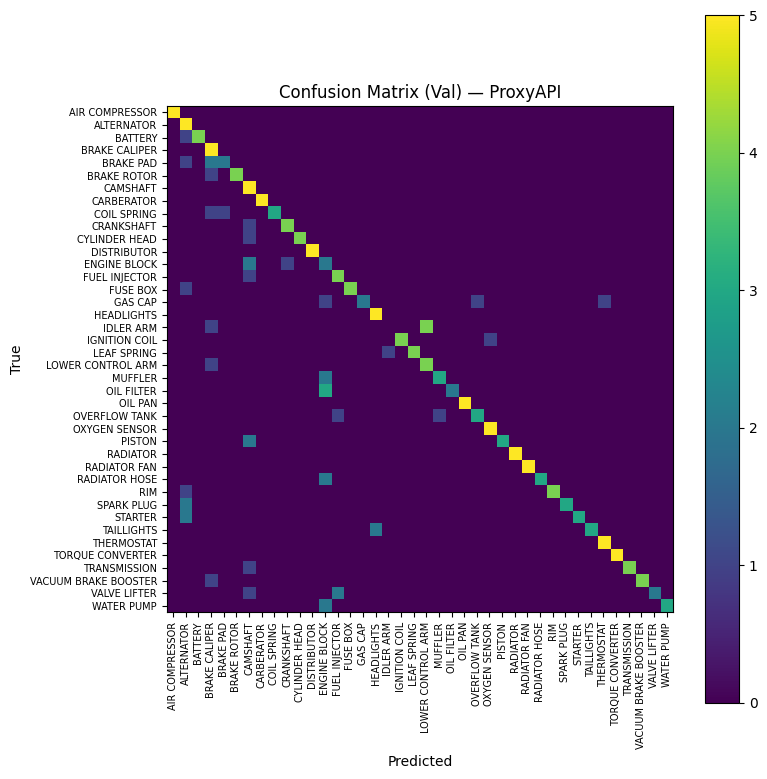


Примеры валидации:


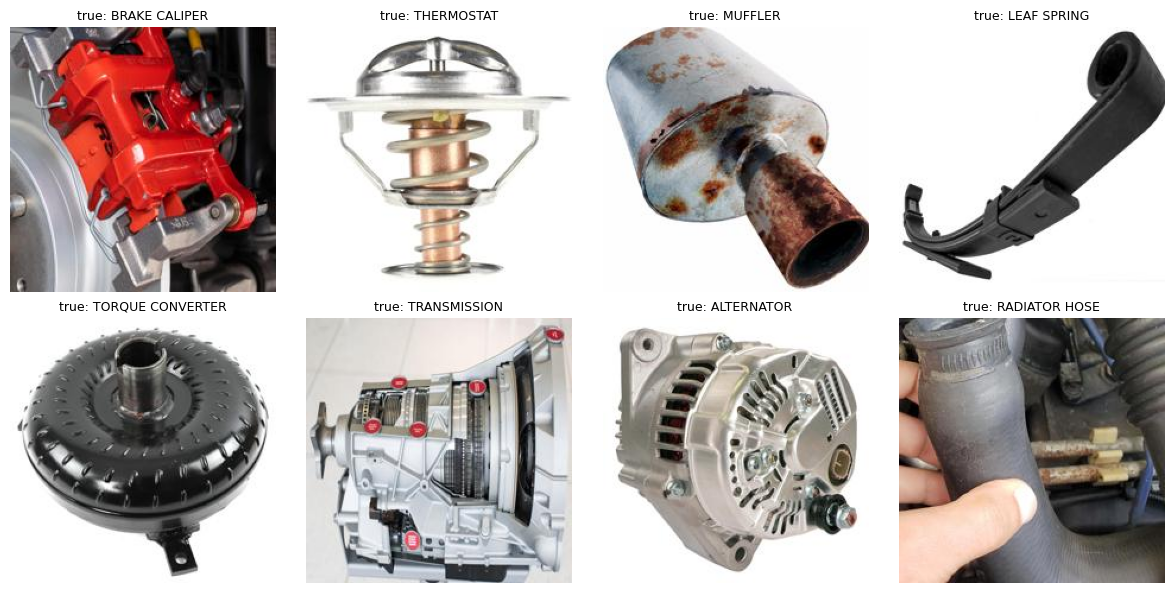

In [20]:
#@title Отчеты и визуализации (строим confusion matrix + примеры)
from sklearn.metrics import classification_report, confusion_matrix

# Отчет по валидации
print("\nVAL classification report (усечен):\n")
print(classification_report(y_true_v, y_pred_v, target_names=label_options)[:2000], "...")

# Confusion matrix (val)
cm = confusion_matrix(y_true_v, y_pred_v, labels=list(range(len(label_options))))
np.save(OUT_DIR / "cm_val_proxy.npy", cm)

plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (Val) — ProxyAPI")
plt.colorbar()
ticks = np.arange(len(label_options))
plt.xticks(ticks, label_options, rotation=90, fontsize=7)
plt.yticks(ticks, label_options, fontsize=7)
plt.tight_layout()
plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

# Примеры предсказаний: по 6 изображений
def show_examples(root_dir: Path, n: int = 6):
    pairs = list_images_and_labels(root_dir)
    rng = np.random.RandomState(0)
    sel = rng.choice(len(pairs), size=min(n, len(pairs)), replace=False)
    plt.figure(figsize=(12, 6))
    for k, idx in enumerate(sel, 1):
        p, y = pairs[idx]
        key = _md5_for_cache(p, label_options)
        rec = cache.get(key, None)
        title = f"true: {label_options[y]}"
        pred_lab = "?"
        if rec:
            top = rec["top"]
            if top:
                pred_lab = top[0]["label"]
                title += f"\npred: {pred_lab} ({top[0].get('score', 0):.2f})"
        img = Image.open(p).convert("RGB")
        plt.subplot(2, (n+1)//2, k)
        plt.imshow(img); plt.axis("off"); plt.title(title, fontsize=9)
    plt.tight_layout(); plt.show()

print("\nПримеры валидации:")
show_examples(VAL_DIR, n=8)

In [21]:
#@title Сохранение «артефактов» эксперимента ProxyAPI (карта меток, сводная таблица)
import pandas as pd

# Карта меток
label_map_path = OUT_DIR / "label_map_proxy.json"
with open(label_map_path, "w", encoding="utf-8") as f:
    json.dump({i: c for i, c in enumerate(label_options)}, f, ensure_ascii=False, indent=2)

# Сводка метрик
rows = [dict(split="val", acc=float(val_acc), top5=float(val_top5), f1=float(val_f1))]
try:
    rows.append(dict(split="test", acc=float(test_acc), top5=float(test_top5), f1=float(test_f1)))
except NameError:
    pass

df = pd.DataFrame(rows)
df_path = OUT_DIR / "proxy_metrics.csv"
df.to_csv(df_path, index=False)
df

,split,acc,top5,f1
0,val,0.750,0.975,0.760915
1,test,0.695,0.985,0.693534


In [22]:
#@title Быстрый инференс одной картинки через ProxyAPI (топ-5 для веб-обертки)
from IPython.display import display

def proxy_top5(image_path: str, k: int = 5):
    p = Path(image_path)
    key = _md5_for_cache(p, label_options)
    if key in cache:
        top = cache[key]["top"]
    else:
        top_pairs = proxy_predict_labels(client, p, label_options, model=PROXY_MODEL)
        s = sum(max(0.0, sc) for _, sc in top_pairs) or 1.0
        top = [{"label": lab, "score": float(sc/s)} for lab, sc in top_pairs]
        cache_append(key, {"image": str(p), "top": top})
    return top[:k]

# Пример:
some_img = str((VAL_DIR / label_options[0]).glob("*.jpg").__iter__().__next__())
proxy_top5(some_img)

[{'label': 'AIR COMPRESSOR', 'score': 0.8181818181818181},
 {'label': 'RADIATOR FAN', 'score': 0.09090909090909091},
 {'label': 'MUFFLER', 'score': 0.045454545454545456},
 {'label': 'STARTER', 'score': 0.027272727272727268},
 {'label': 'WATER PUMP', 'score': 0.01818181818181818}]